<a href="https://colab.research.google.com/github/PeterDeWeirdt/rs_dev/blob/main/notebooks/03_build_seq_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Sequence Model

In [1]:
!pip install -U --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install -U lightgbm --install-option=--gpu
!pip install sglearn
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.4MB 134kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5MB 7.6MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
    Running setup.py install for lightgbm ... done
     |████████████████████████████████| 2.3MB 8.0MB/s 
     |████████████████████████████████| 296kB 9.1MB/s 
     |████████████████████████

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Requirement already up-to-date: lightgbm in /usr/local/lib/python3.7/dist-packages (3.2.0)


In [2]:
import pandas as pd
from datasets_colab import dataset_list
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score
import sglearn
from scipy import stats
import plotnine as gg
import optuna
from joblib import Parallel, delayed
import numpy as np
from tensorflow import keras
from datetime import datetime


In [3]:
def get_predictive_performance(prediction_list):
    """From a list of dataframes of predictions for each fold for each datasetset for each guide,
    get pearson correlation of each fold/dataset

    :param prediction_list: list of DataFrame
    :return: DataFrame
    """
    test_prediction_df = (pd.concat(prediction_list)
                          .rename({'dataset': 'testing_set'}, axis=1))
    predictive_performance = (test_prediction_df.groupby(['model_name', 'testing_set', 'fold'])
                              .apply(lambda df: stats.pearsonr(df['sgRNA Activity'], df['prediction'])[0])
                              .reset_index(name='pearson_r'))
    predictive_performance['relative_performance'] = (predictive_performance.groupby(['fold', 'testing_set'])
                                                      ['pearson_r']
                                                      .transform(lambda x: x/x.max()))
    median_relative_performance = (predictive_performance.groupby(['model_name'])
                                   .agg(median_performance = ('relative_performance', 'median'))
                                   .reset_index()
                                   .sort_values('median_performance'))
    predictive_performance['model_name'] = pd.Categorical(predictive_performance['model_name'],
                                                            categories=median_relative_performance['model_name'])
    if predictive_performance['testing_set'].isin(predictive_performance['model_name']).all():
        predictive_performance['testing_set'] = pd.Categorical(predictive_performance['testing_set'],
                                                               categories=median_relative_performance['model_name'])
    predictive_performance['fold'] = predictive_performance['fold'].astype('category')
    return predictive_performance


def plot_pearson_heatmap(predictive_performance):
    """Plot heatmap of pearson correlations

    :param predictive_performance: DataFrame from `get_predictive_performance`
    :return: plotnine figure
    """
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='testing_set', y='model_name', fill='pearson_r') +
         gg.geom_tile(color='black') +
         gg.scale_fill_cmap('RdBu_r', limits=(-1, 1)) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)) +
         gg.facet_wrap('fold'))
    return g


def plot_relative_performance(predictive_performance):
    """Plot boxplot of relative performance

    :param predictive_performance: predictive_performance: DataFrame from `get_predictive_performance`
    :return: plotnine figure
    """
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='model_name', y='relative_performance') +
         gg.geom_point(gg.aes(color='fold'), position=gg.position_dodge(width=0.5)) +
         gg.scale_color_brewer(type='qual', palette='Set2') +
         gg.geom_boxplot(fill=None, outlier_alpha=0) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)))
    return g


def train_test_model(train_df, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    X_train = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    X_train.columns = X_train.columns.str.replace(',', '')
    y_train = train_df['sgRNA Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7, device='gpu'),
                         top_training_set=None, combine_datasets=None, model_name=None):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param top_training_set: str
    :param combine_datasets: list of
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_prediction_list = []
    if combine_datasets is None:
        for dataset, dataset_df in fold_train_data.groupby('dataset'):
            dataset_df = dataset_df.reset_index(drop=True)
            # Join together top training set and current dataset
            if top_training_set is not None:
                if dataset != top_training_set:
                    top_dataset_df = fold_train_data[fold_train_data.dataset == top_training_set]
                    dataset_df = pd.concat([dataset_df, top_dataset_df]).reset_index(drop=True)
                    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                                    ['sgRNA Activity']
                                                    .rank(pct=True))
                    dataset += ' + ' + top_training_set
            model = clone(base_model)
            dataset_test_predictions = train_test_model(dataset_df, dataset, fold, model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    else:
        train_df = fold_train_data[fold_train_data.dataset.isin(combine_datasets)].reset_index(drop=True)
        train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                      ['sgRNA Activity']
                                      .rank(pct=True))
        model = clone(base_model)
        if model_name is None:
            model_name = ' + '.join(combine_datasets)
        dataset_test_predictions = train_test_model(train_df, model_name, fold,
                                                    model, fold_test_data, X_test)
        # For consistency we return a list of len 1
        test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

In [4]:
train_data_names = pd.read_csv('train_data_names.csv').name.to_list()

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.get_sgrnas()

## Cross-Validation Iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

>This cross-validation object is a variation of StratifiedKFold attempts to return stratified folds with
> non-overlapping groups. The folds are made by preserving the percentage of samples for each class.

>The same group will not appear in two different folds (the number of distinct groups has to be at least equal to
> the number of folds).

>The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such
> that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to
> create folds which preserve the percentage of samples for each class as much as possible given the
> constraint of non-overlapping groups between splits.

In our case, we define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

In [6]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])                      
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10604
1,1,True,Kim2019_train,10574
2,4,True,Kim2019_train,10354
3,0,True,Kim2019_train,10267
4,2,True,Kim2019_train,9529
5,2,False,Kim2019_train,3303
6,0,False,Kim2019_train,2565
7,4,False,Kim2019_train,2478
8,1,True,Doench2016,2319
9,1,False,Kim2019_train,2258


In [8]:
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n'))

,cv,dataset,n
0,4,Wang2014,2
1,2,Doench2014_mouse,2
2,0,Doench2014_mouse,2
3,0,Doench2016,2
4,0,Kim2019_train,2
5,0,Wang2014,2
6,1,Doench2014_human,2
7,1,Doench2014_mouse,2
8,1,Doench2016,2
9,1,Kim2019_train,2


The size of the training and testing sets are approximately equal across folds,
with training sets varying between 13,107 (fold 2) - 15,847 (fold 3) sgRNAs and testing sets varying
between 2,707 (fold 3) - 5,447 (fold 2) sgRNAs


In [9]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
6,0,False,3843
3,0,True,14711
8,1,False,3033
1,1,True,15521
5,2,False,5447
4,2,True,13107
9,3,False,2707
0,3,True,15847
7,4,False,3524
2,4,True,15030


Indeed each gene target (gene) only appears in one fold

In [10]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Train each dataset separately
Now we'll move onto training and first we'll train each dataset separately

In [11]:
single_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    single_test_prediction_list.extend(get_fold_predictions(fold, df))
    print('\n')

single_predictive_performance = get_predictive_performance(single_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




Importantly, all training datasets are successful at predicting held-out test data

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



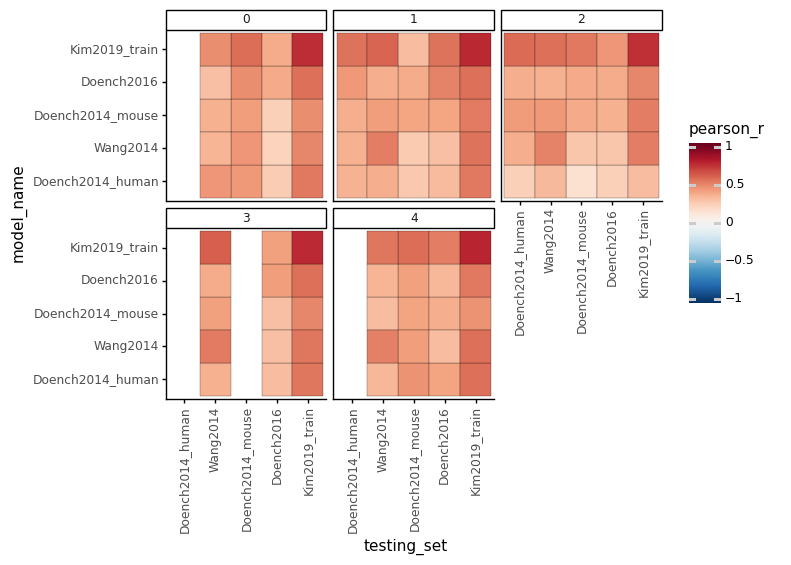

<ggplot: (8763429345117)>

In [12]:
plot_pearson_heatmap(single_predictive_performance)

We can see that the Kim training data outperforms all the rest, but it's also quite a bit bigger than the next biggest dataset

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



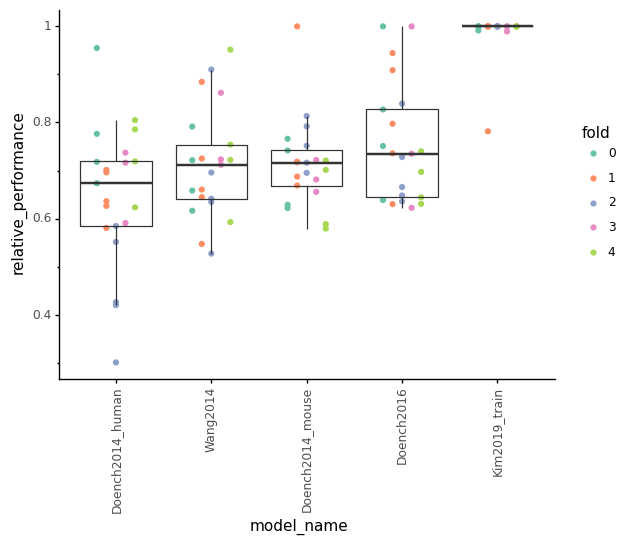

<ggplot: (8763432288721)>

In [13]:
plot_relative_performance(single_predictive_performance)


## Combining training datasets

If we merge the training datasets, can we improve our performance?
We'll merge by normalizing activity to a percent rank.

In [14]:
top_training_set = (single_predictive_performance.groupby('model_name')
                    .agg({'relative_performance': 'median'})
                    .reset_index()
                    .sort_values('relative_performance', ascending=False)
                    ['model_name']
                    .values[0])
print('Top training set: ' + top_training_set)

Top training set: Kim2019_train


In [15]:
combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: '+ str(fold))
    combined_test_prediction_list.extend(get_fold_predictions(fold, df, top_training_set=top_training_set))
    print('\n')

combined_predictive_performance = get_predictive_performance(combined_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



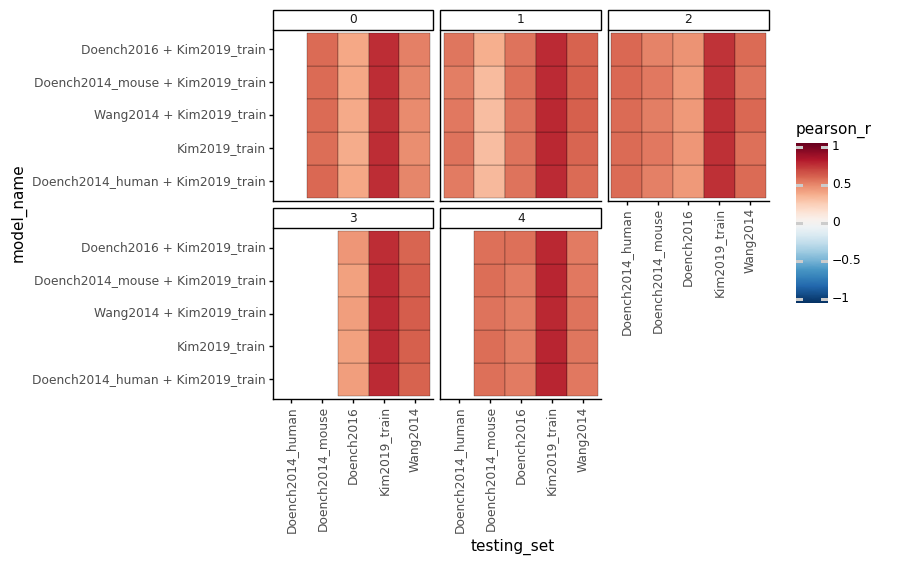

<ggplot: (8763361589857)>

In [16]:
plot_pearson_heatmap(combined_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



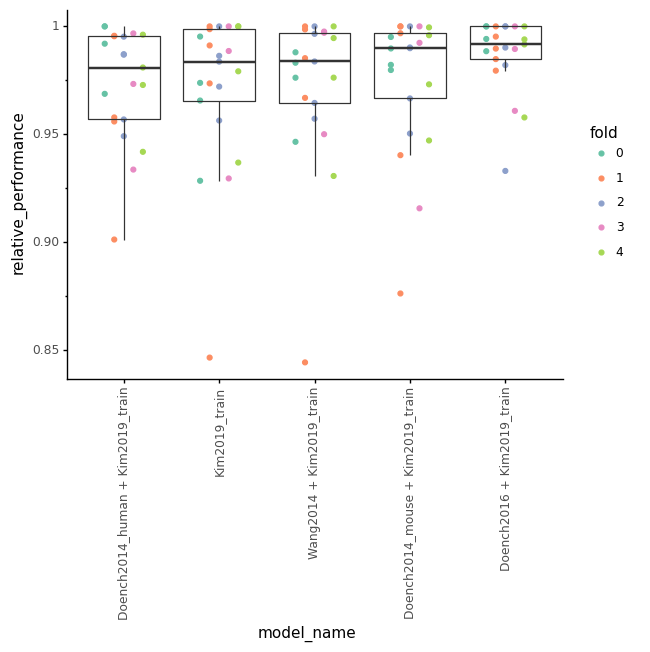

<ggplot: (8763365910333)>

In [17]:
plot_relative_performance(combined_predictive_performance)

We'll keep all training sets that don't significantly reduce predictive performance, which is all training sets

In [18]:
ttest_list = []
reference_scores = (combined_predictive_performance
                    .loc[combined_predictive_performance['model_name'] == top_training_set, 'pearson_r'])
for model_name, training_set_df in combined_predictive_performance.groupby('model_name'):
    compare_scores = training_set_df['pearson_r']
    t, p = stats.ttest_rel(reference_scores, compare_scores)
    ttest_list.append({'model_name': model_name, 't': t, 'p': p})
ttest_df = pd.DataFrame(ttest_list)
ttest_df.sort_values('t')

,model_name,t,p
4,Doench2016 + Kim2019_train,-1.370410,0.185746
3,Doench2014_mouse + Kim2019_train,-0.580031,0.568371
2,Wang2014 + Kim2019_train,-0.291645,0.773562
0,Doench2014_human + Kim2019_train,-0.007816,0.993841
1,Kim2019_train,NaN,NaN


We'll try combining all datasets which don't significantly decrease performance

In [19]:
combine_datasets =  (ttest_df
    .loc[(ttest_df.t.fillna(0) < 0) | (ttest_df.p.fillna(1) > 0.05), 'model_name']
    .str.split(' \+ ', expand=True)[0])
print('Combine datasets: ' + ', '.join(combine_datasets))

Combine datasets: Doench2014_human, Kim2019_train, Wang2014, Doench2014_mouse, Doench2016


In [20]:
top_combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    top_combined_test_prediction_list.extend(get_fold_predictions(fold, df, combine_datasets=combine_datasets,
                                                                  model_name='All train data'))
    print('\n')

top_dual_model = ttest_df.sort_values('t')['model_name'].values[0]
print('Reference model: ' + str(top_dual_model))
top_dual_prediction_list = [df for df in combined_test_prediction_list if (df.model_name == top_dual_model).all()]
top_combined_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                                 top_dual_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4


Reference model: Doench2016 + Kim2019_train


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



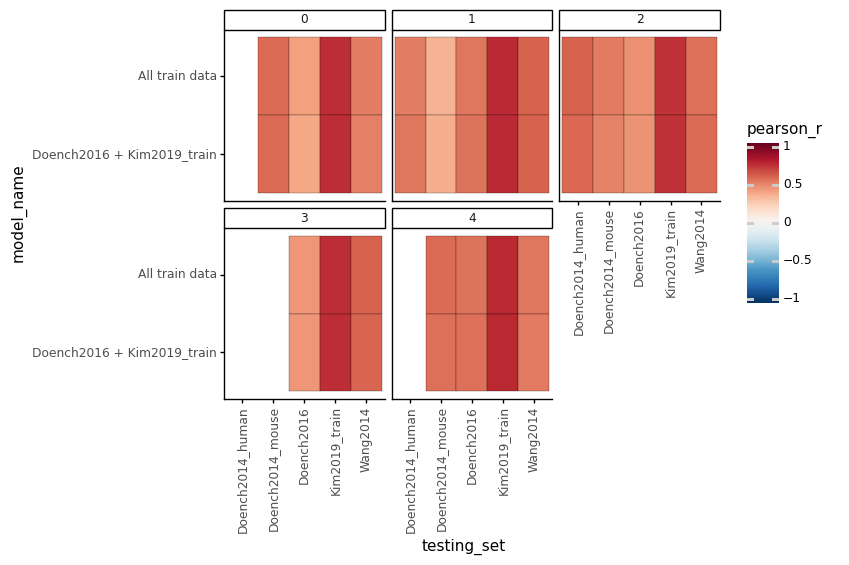

<ggplot: (8763436428105)>

In [21]:
plot_pearson_heatmap(top_combined_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



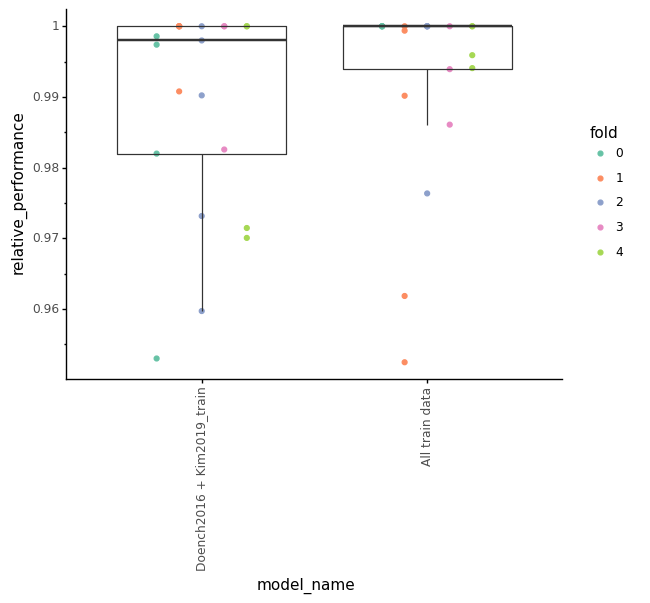

<ggplot: (8763352175189)>

In [22]:
plot_relative_performance(top_combined_predictive_performance)

## Sequence Model Hyperparameter Tuning

Using the combined datasets, we'll try different model architectures and use hyperparameter tuning.
For the hyperparmeter tuning, we'll use the [optuna library](https://optuna.readthedocs.io/en/stable/index.html),
which by default uses the Tree-structured Parzen Estimator to search the hyperparameter space.

In [24]:
n_trials = 2

### LightGBM

In [26]:
def lgbm_training_iteration(fold_df, train_index, test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence']) # train and validation data
    X_train_val.columns = X_train_val.columns.str.replace(',', '') # problem with lgbm regressor c code
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples, device='gpu')
        performance = [lgbm_training_iteration(fold_df, train_index, 
                                               test_index, model) for
                       train_index, test_index in
                       sgkf.split(fold_df, fold_df.dataset, fold_df.target)]
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [27]:
lgbm_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize') # maximize r^2
    objective = get_lgbm_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    X_train_val.columns = X_train_val.columns.str.replace(',', '')
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = LGBMRegressor(random_state=7, learning_rate=0.01, n_estimators=5000, device=='gpu',
                          **trial.params)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All train data + LGBM + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    lgbm_prediction_list.append(test_predictions)

[I 2021-04-11 23:38:08,372] A new study created in memory with name: no-name-ca2bf419-1ebf-4922-a5d8-d802a00c5a67


Fold: 0


[I 2021-04-11 23:39:37,112] Trial 0 finished with value: 0.46556756656931064 and parameters: {'num_leaves': 131, 'min_child_samples': 248}. Best is trial 0 with value: 0.46556756656931064.
[I 2021-04-11 23:41:05,039] Trial 1 finished with value: 0.4668744537222512 and parameters: {'num_leaves': 195, 'min_child_samples': 252}. Best is trial 1 with value: 0.4668744537222512.


Number of finished trials: 2
Training Time: 0:02:56.665981
Best trial:
  Value: 0.4668744537222512
  Params: 
    num_leaves: 195
    min_child_samples: 252
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.044941
[2000]	valid_0's l2: 0.0429874
Early stopping, best iteration is:
[2197]	valid_0's l2: 0.04281


[I 2021-04-11 23:41:29,229] A new study created in memory with name: no-name-674ee449-3599-4f20-843c-d01ff0c49827


Fold: 1


[I 2021-04-11 23:42:53,236] Trial 0 finished with value: 0.4466779364568307 and parameters: {'num_leaves': 67, 'min_child_samples': 65}. Best is trial 0 with value: 0.4466779364568307.
[I 2021-04-11 23:44:19,618] Trial 1 finished with value: 0.44510066637420237 and parameters: {'num_leaves': 127, 'min_child_samples': 245}. Best is trial 0 with value: 0.4466779364568307.


Number of finished trials: 2
Training Time: 0:02:50.387831
Best trial:
  Value: 0.4466779364568307
  Params: 
    num_leaves: 67
    min_child_samples: 65
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0449079
Early stopping, best iteration is:
[1112]	valid_0's l2: 0.044764


[I 2021-04-11 23:44:39,493] A new study created in memory with name: no-name-77542f4f-47a8-4ddd-9196-595822a24eef


Fold: 2


[I 2021-04-11 23:45:49,966] Trial 0 finished with value: 0.45873604150051667 and parameters: {'num_leaves': 22, 'min_child_samples': 116}. Best is trial 0 with value: 0.45873604150051667.
[I 2021-04-11 23:47:02,828] Trial 1 finished with value: 0.4277045108239996 and parameters: {'num_leaves': 185, 'min_child_samples': 16}. Best is trial 0 with value: 0.45873604150051667.


Number of finished trials: 2
Training Time: 0:02:23.334677
Best trial:
  Value: 0.45873604150051667
  Params: 
    num_leaves: 22
    min_child_samples: 116
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0438216
Early stopping, best iteration is:
[1886]	valid_0's l2: 0.0420802


[I 2021-04-11 23:47:21,776] A new study created in memory with name: no-name-8f0b0843-7091-4054-af48-a7f3bf4f3672


Fold: 3


[I 2021-04-11 23:48:51,388] Trial 0 finished with value: 0.451214342661839 and parameters: {'num_leaves': 158, 'min_child_samples': 221}. Best is trial 0 with value: 0.451214342661839.
[I 2021-04-11 23:50:23,247] Trial 1 finished with value: 0.45144974888737754 and parameters: {'num_leaves': 91, 'min_child_samples': 220}. Best is trial 1 with value: 0.45144974888737754.


Number of finished trials: 2
Training Time: 0:03:01.470131
Best trial:
  Value: 0.45144974888737754
  Params: 
    num_leaves: 91
    min_child_samples: 220
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0446565
Early stopping, best iteration is:
[1820]	valid_0's l2: 0.0433583


[I 2021-04-11 23:50:46,177] A new study created in memory with name: no-name-aea3abc7-da39-4a9d-a4e8-664b8b429f26


Fold: 4


[I 2021-04-11 23:52:11,301] Trial 0 finished with value: 0.4529520666295744 and parameters: {'num_leaves': 32, 'min_child_samples': 225}. Best is trial 0 with value: 0.4529520666295744.
[I 2021-04-11 23:53:38,902] Trial 1 finished with value: 0.4542789999431923 and parameters: {'num_leaves': 164, 'min_child_samples': 166}. Best is trial 1 with value: 0.4542789999431923.


Number of finished trials: 2
Training Time: 0:02:52.724509
Best trial:
  Value: 0.4542789999431923
  Params: 
    num_leaves: 164
    min_child_samples: 166
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0452642
Early stopping, best iteration is:
[1152]	valid_0's l2: 0.0450617


In [28]:
lgbm_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                         lgbm_prediction_list)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



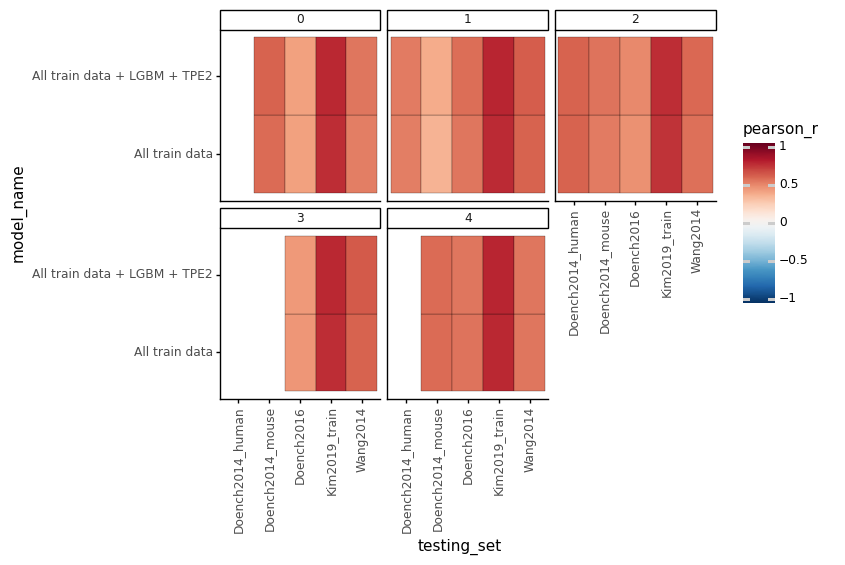

<ggplot: (8763393178677)>

In [29]:
plot_pearson_heatmap(lgbm_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



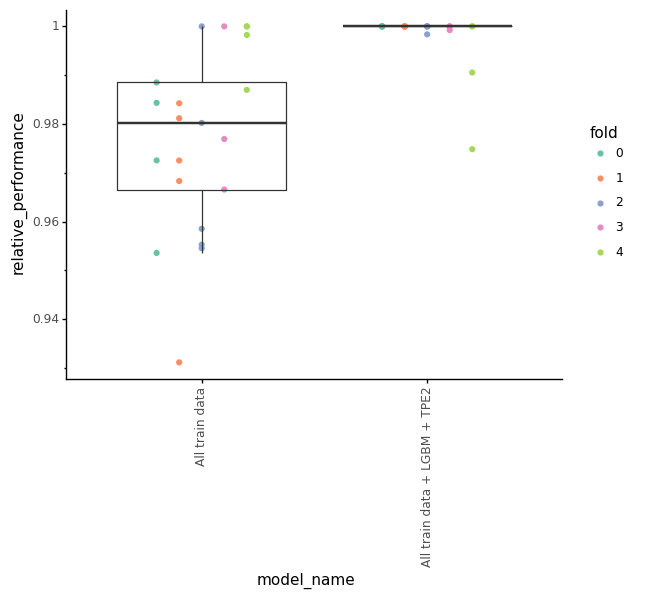

<ggplot: (8763361094077)>

In [30]:
plot_relative_performance(lgbm_predictive_performance)


### Keras Convolutional Neural Network

In [31]:
def get_cnn(n_conv_layers, filters_per_conv, filter_len,
            nodes_per_dense, dense_dropout_rate, n_dense_layers=1,
            input_shape=(30, 4), activation='relu', initializer='he_uniform',
            pool_size=2, loss='mse', optimizer='Adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for _ in range(n_conv_layers):
        model.add(keras.layers.Conv1D(filters=filters_per_conv, kernel_size=filter_len,
                                      activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.AveragePooling1D(pool_size=pool_size))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(dense_dropout_rate))
    for _ in range(n_dense_layers):
        model.add(keras.layers.Dense(nodes_per_dense, activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(dense_dropout_rate))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

nt_codes = {'A':[1,0,0,0],
            'C':[0,1,0,0],
            'G':[0,0,1,0],
            'T':[0,0,0,1]}

def encode_seqs(seqs):
    # 3d array with samples x position x nt
    encoded_seqs = np.array([[nt_codes.get(x) for x in seq] for seq in seqs])
    return encoded_seqs


def cnn_training_iteration(fold_df, train_index, test_index, base_model):
    """Train cnn model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: KerasRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = clone(base_model)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = encode_seqs(test_df['sgRNA Context Sequence'])
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_cnn_objective(fold_df):
    """Get objective function for training a cnn model

    :param fold_df: DataFrame
    :return: objective function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for cnn

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        n_conv_layers = trial.suggest_int('n_conv_layers', 1, 2)
        filters_per_conv = trial.suggest_int('filters_per_conv', 32, 512)
        filter_len = trial.suggest_int('filter_len', 2, 8)
        nodes_per_dense = trial.suggest_int('nodes_per_dense', 8, 256)
        dense_dropout_rate = trial.suggest_float('dense_dropout_rate', 0.1, 0.5)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                           n_conv_layers=n_conv_layers,
                                                           filters_per_conv=filters_per_conv,
                                                           filter_len=filter_len,
                                                           nodes_per_dense=nodes_per_dense,
                                                           dense_dropout_rate=dense_dropout_rate)
        performance = [cnn_training_iteration(fold_df, train_index, 
                                              test_index, model) for
                       train_index, test_index in
                       sgkf.split(fold_df, fold_df.dataset, fold_df.target)]
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [32]:
cnn_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize') # maximize r^2
    objective = get_cnn_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                       **trial.params)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = encode_seqs(fold_test_data['sgRNA Context Sequence'])
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All train data + CNN + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    cnn_prediction_list.append(test_predictions)

[I 2021-04-11 23:54:27,942] A new study created in memory with name: no-name-77af0c68-d77c-4797-90cf-8633f3aa86f3


Fold: 0


[I 2021-04-11 23:57:10,090] Trial 0 finished with value: 0.3930900769238017 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 38, 'filter_len': 5, 'nodes_per_dense': 223, 'dense_dropout_rate': 0.170746526726066}. Best is trial 0 with value: 0.3930900769238017.
[I 2021-04-12 00:00:07,319] Trial 1 finished with value: 0.4227702985336779 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 458, 'filter_len': 4, 'nodes_per_dense': 201, 'dense_dropout_rate': 0.2017913832565492}. Best is trial 1 with value: 0.4227702985336779.


Number of finished trials: 2
Training Time: 0:05:39.381797
Best trial:
  Value: 0.4227702985336779
  Params: 
    n_conv_layers: 1
    filters_per_conv: 458
    filter_len: 4
    nodes_per_dense: 201
    dense_dropout_rate: 0.2017913832565492


[I 2021-04-12 00:00:29,211] A new study created in memory with name: no-name-c6edbf7f-ee2c-4b40-8a61-b6f7f8b22b19


Fold: 1


[I 2021-04-12 00:03:19,791] Trial 0 finished with value: 0.4024880746540266 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 249, 'filter_len': 5, 'nodes_per_dense': 134, 'dense_dropout_rate': 0.33056014528102007}. Best is trial 0 with value: 0.4024880746540266.
[I 2021-04-12 00:06:12,631] Trial 1 finished with value: 0.37334504778857314 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 391, 'filter_len': 6, 'nodes_per_dense': 138, 'dense_dropout_rate': 0.24502508111013566}. Best is trial 0 with value: 0.4024880746540266.


Number of finished trials: 2
Training Time: 0:05:43.419210
Best trial:
  Value: 0.4024880746540266
  Params: 
    n_conv_layers: 2
    filters_per_conv: 249
    filter_len: 5
    nodes_per_dense: 134
    dense_dropout_rate: 0.33056014528102007


[I 2021-04-12 00:06:50,561] A new study created in memory with name: no-name-eac2dc93-3104-4cf6-8450-4148fbb3e15d


Fold: 2


[I 2021-04-12 00:08:54,355] Trial 0 finished with value: 0.4080464090802355 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 34, 'filter_len': 5, 'nodes_per_dense': 67, 'dense_dropout_rate': 0.16063666741976254}. Best is trial 0 with value: 0.4080464090802355.
[I 2021-04-12 00:13:00,301] Trial 1 finished with value: 0.41457093888994284 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 47, 'filter_len': 2, 'nodes_per_dense': 40, 'dense_dropout_rate': 0.2393151082250345}. Best is trial 1 with value: 0.41457093888994284.


Number of finished trials: 2
Training Time: 0:06:09.738674
Best trial:
  Value: 0.41457093888994284
  Params: 
    n_conv_layers: 1
    filters_per_conv: 47
    filter_len: 2
    nodes_per_dense: 40
    dense_dropout_rate: 0.2393151082250345


[I 2021-04-12 00:13:56,525] A new study created in memory with name: no-name-feacf80d-30d1-4f0e-863d-130eddd18676


Fold: 3


[I 2021-04-12 00:17:07,124] Trial 0 finished with value: 0.41752133175555706 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 406, 'filter_len': 7, 'nodes_per_dense': 243, 'dense_dropout_rate': 0.12937809352330257}. Best is trial 0 with value: 0.41752133175555706.
[I 2021-04-12 00:20:07,268] Trial 1 finished with value: 0.40803923627670524 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 243, 'filter_len': 7, 'nodes_per_dense': 36, 'dense_dropout_rate': 0.24589628292667595}. Best is trial 0 with value: 0.41752133175555706.


Number of finished trials: 2
Training Time: 0:06:10.742247
Best trial:
  Value: 0.41752133175555706
  Params: 
    n_conv_layers: 1
    filters_per_conv: 406
    filter_len: 7
    nodes_per_dense: 243
    dense_dropout_rate: 0.12937809352330257


[I 2021-04-12 00:20:49,401] A new study created in memory with name: no-name-1c4205d9-9f43-46cf-9336-6e0acb28bf55


Fold: 4


[I 2021-04-12 00:23:40,285] Trial 0 finished with value: 0.409051389113431 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 139, 'filter_len': 7, 'nodes_per_dense': 54, 'dense_dropout_rate': 0.1745035734423856}. Best is trial 0 with value: 0.409051389113431.
[I 2021-04-12 00:28:43,948] Trial 1 finished with value: 0.4350758982325037 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 431, 'filter_len': 7, 'nodes_per_dense': 219, 'dense_dropout_rate': 0.4739325723192759}. Best is trial 1 with value: 0.4350758982325037.


Number of finished trials: 2
Training Time: 0:07:54.545429
Best trial:
  Value: 0.4350758982325037
  Params: 
    n_conv_layers: 1
    filters_per_conv: 431
    filter_len: 7
    nodes_per_dense: 219
    dense_dropout_rate: 0.4739325723192759


In [33]:
cnn_predictive_performance = get_predictive_performance(lgbm_prediction_list +
                                                        cnn_prediction_list)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



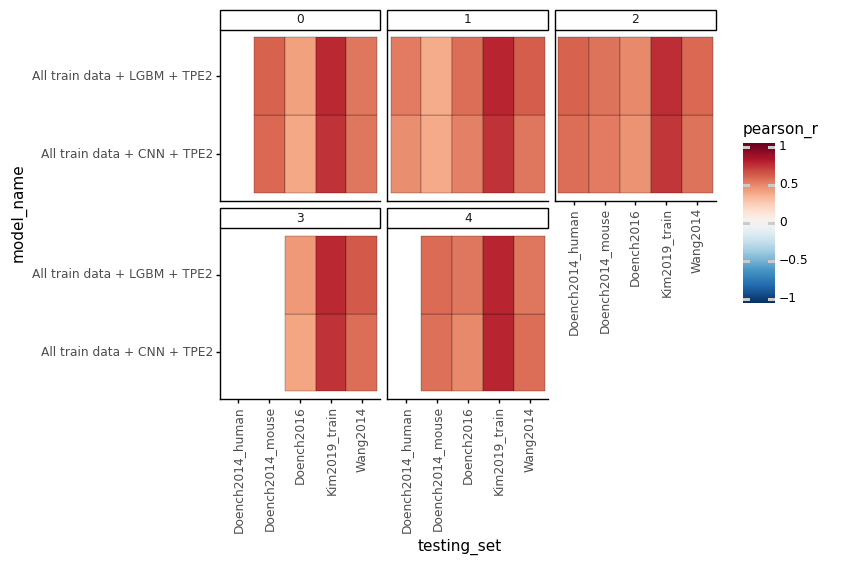

<ggplot: (8763357619409)>

In [34]:
plot_pearson_heatmap(cnn_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



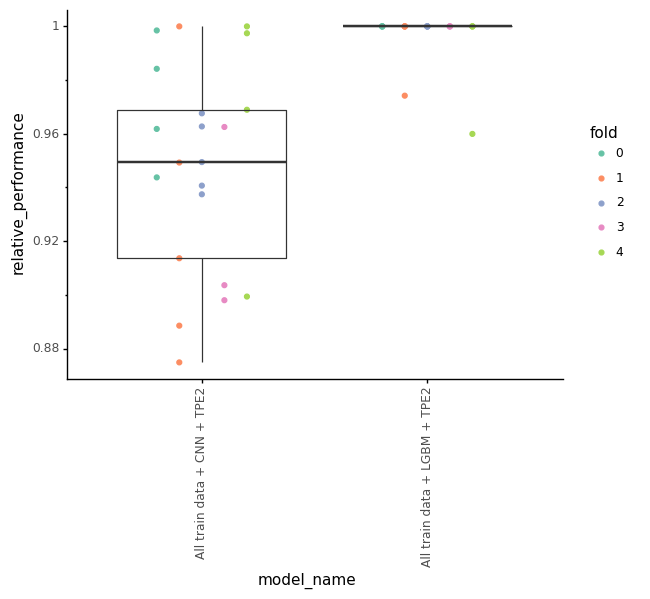

<ggplot: (8763361798289)>

In [35]:
plot_relative_performance(cnn_predictive_performance)